## Neural style transfer

Leon Gatys et al.에 의해 2015년에 소개되었습니다.

그 이후로 많은 변형(예: 스마트폰 사진 앱의 많은 응용 프로그램)

**Neural style transfer**: 대상 이미지의 내용(content)을 보존하면서 참조 이미지의 스타일을 대상 이미지에 적용합니다.

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/12-09.png" width="500"><p style="text-align:center">Figure 12.9 A style transfer example</p>

스타일(Style) : 다양한 공간 척도에서 이미지의 질감, 색상 및 시각적 패턴

내용(Content): 이미지의 상위 수준 매크로 구조

**목표**

> 원본 이미지의 내용(Content) 보존
>
> 참조 이미지의 스타일(Style)을 조정하면서

콘텐츠와 스타일을 정의할 수 있다면 다음을 최소화하려고 합니다.

```
loss = (distance(style(reference_image) - style(combination_image)) +
        distance(content(original_image - content(combination_image))
```

### The content loss

네트워크의 앞쪽 층(earlier layers)에서의 활성화에는 이미지에 대한 로컬 정보가 포함됩니다.

상위 계층(higher layers )의 활성화에는 점점 더 글로벌하고 추상적인 정보가 포함됩니다.

Content loss: 다음 사이의 L2 norm:

* 대상 이미지에 대해 계산된 사전 훈련된 convnet에서 상위 계층의 활성화

* 생성된 이미지에 대해 계산된 동일한 레이어의 활성화


### The style loss

content 와 유사하지만 여러 레이어(다른 공간 척도)

**Gram matrix**: 주어진 레이어의 특징 맵의 내적


### Neural style transfer in Keras

* 세 이미지 모두에 대해 VGG19 레이어 활성화를 계산하는 네트워크
* 손실 계산
* 손실을 최소화하기 위한 경사하강법

**Getting the style and content images**

In [1]:
from tensorflow import keras

base_image_path = keras.utils.get_file(
    "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg")
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/12-10.png" width="500"><p style="text-align:center">Figure 12.10 Content image: San Francisco from Nob Hill</p>

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/12-11.png" width="500"><p style="text-align:center">Figure 12.11 Style image: Starry Night by Van Gogh</p>

**Auxiliary functions**

In [2]:
import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(
        image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

**Using a pretrained VGG19 model to create a feature extractor**

In [3]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

**Content loss**

In [4]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

**Style loss**

In [5]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

**Total variation loss**

In [6]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

**Defining the final loss that you'll minimize**

In [7]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
          style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

**Setting up the gradient-descent process**

In [8]:
import tensorflow as tf

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 1000 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

Iteration 100: loss=8137.63
Iteration 200: loss=6653.13
Iteration 300: loss=6064.05
Iteration 400: loss=5743.33
Iteration 500: loss=5536.64
Iteration 600: loss=5390.82
Iteration 700: loss=5281.57
Iteration 800: loss=5195.99
Iteration 900: loss=5126.90
Iteration 1000: loss=5069.82
Iteration 1100: loss=5021.75
Iteration 1200: loss=4980.65
Iteration 1300: loss=4945.20
Iteration 1400: loss=4914.17
Iteration 1500: loss=4886.88
Iteration 1600: loss=4862.71
Iteration 1700: loss=4841.27
Iteration 1800: loss=4822.09
Iteration 1900: loss=4804.86
Iteration 2000: loss=4789.24
Iteration 2100: loss=4775.01
Iteration 2200: loss=4762.01
Iteration 2300: loss=4750.10
Iteration 2400: loss=4739.13
Iteration 2500: loss=4729.02
Iteration 2600: loss=4719.68
Iteration 2700: loss=4711.05
Iteration 2800: loss=4703.00
Iteration 2900: loss=4695.51
Iteration 3000: loss=4688.57
Iteration 3100: loss=4682.08
Iteration 3200: loss=4675.97
Iteration 3300: loss=4670.25
Iteration 3400: loss=4664.88
Iteration 3500: loss=46

AttributeError: module 'matplotlib.pyplot' has no attribute 'subplots_sdjust'

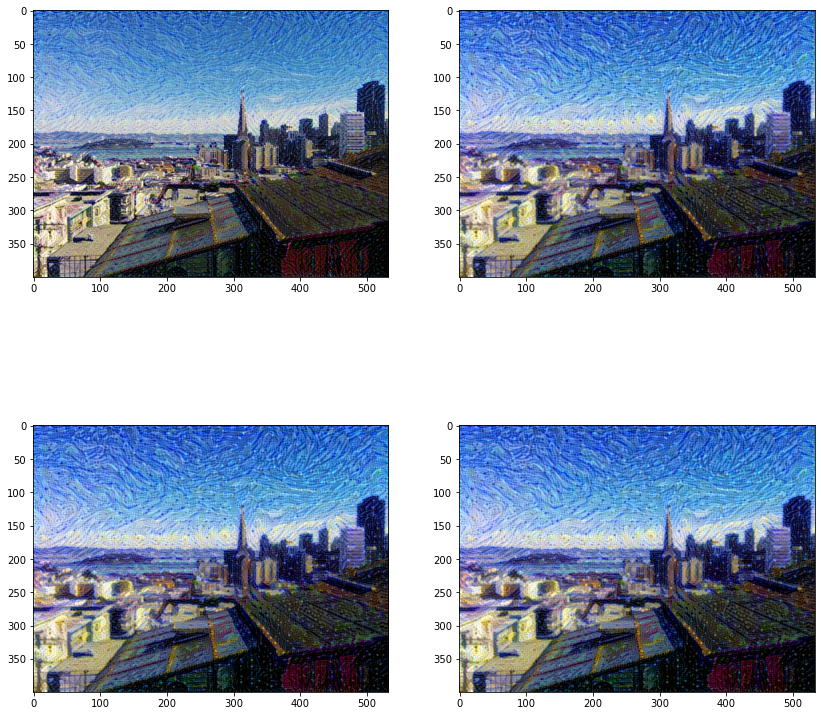

In [12]:
import matplotlib.pyplot as plt
from glob import glob

rows, cols = 2, 2
img_paths = glob("./combination*.png")
img_paths = img_paths[0: len(img_paths): np.ceil(len(img_paths)//(rows*cols)).astype(int)]

_, axs = plt.subplots(rows, cols, figsize=(14,14))
for img_path, ax in zip(img_paths, axs.flatten()):
    ax.imshow(keras.utils.load_img(img_path))
plt.subplots_sdjust(wspace=0, hspace=0)
plt.show()

<img src="https://drek4537l1klr.cloudfront.net/chollet2/Figures/12-12.png" width="500"><p style="text-align:center">Figure 12.12 Style transfer result</p>

이 기술: 이미지 재 텍스처링/텍스처 전이의 형태

알고리즘은 AI보다 고전적인 신호 처리에 가깝습니다.

또한: 실행 속도가 느림

더 빠른 추론(inference)을 위해:

* 많은 입력-출력 훈련 예제 생성(고정된 스타일-참조(style-reference) 이미지)
* 이 스타일별 변환을 배우기 위해 간단한 convnet 훈련
* 훈련 후 추론이 빠름(작은 convnet의 정방향 통과)


### Wrapping up